## Setup Quantification environment

In [1]:
import torch
import matplotlib.pyplot as plt
import os
import torch.nn as nn
from data_preparation import DataHandling 
from datetime import datetime
import json
import numpy as np
import os
import glob
from utils import PairFinder

## Set dataset path

In [2]:
config_file = 'config.json'

with open(config_file, 'r') as f:
    config = json.load(f)

ga_data_dir = config["ga_data_dir"]
fdg_data_dir = config["fdg_data_dir"]
log_dir = config["log_dir"]
ga_output_dir = config["ga_output_dir"]
artifact_dir = config["artifacts"]
artifact_output = config ["artifact_output"]
fdg_output_dir = config['fdg_output_dir']

In [ ]:

# hint = 'dl_dyn3'
# hint3 = 'gamodel_3_18_onfdg'
# hint = 'gamodel_onfdg'
# hint = 'test_corr2'
# hint = 'comb_3_27_11_26_onfdg'
# hint = 'comb_3_27_11_26_onga'
#hint = 'comb_3_27_11_26_onfdg_spacing'
# hint = 'dl_dyn1'


In [ ]:

# hint5 = 'comb_3_27_onfdg_v2'
# pair_finder_dl3_18 = PairFinder(f'{fdg_data_dir}/MAC', fdg_output_dir, hint5)

# hint4 = 'dl_final_3_29_v2'
# pair_finder_adcm = PairFinder(f'{fdg_data_dir}/MAC', fdg_output_dir, hint4)
# all_pairs_adcm, c5_pairs_adcm, rest_pairs_adcm = pair_finder_adcm.find_file_pairs()
# print(len(all_pairs_adcm), len(c5_pairs_adcm), len(rest_pairs_adcm))

In [19]:
hint1 = 'dl3_18' # ga_data_dir  ga_output_dir
hint1 = 'dl4_23' # ga_data_dir  ga_output_dir
hint1 =  'comb_4_5_onfdg' # fdg_data_dir  fdg_output_dir

pair_finder_dl3_18 = PairFinder(f'{fdg_data_dir}/NAC', f'{fdg_data_dir}/MAC', fdg_output_dir, hint1)
center_pairs_dyn  = pair_finder_dl3_18.find_file_triples()



hint2 = 'dl_final' # ga_data_dir  ga_output_dir
hint2 = 'final_4_26' # ga_data_dir  ga_output_dir
hint2 = 'final_4_26' # fdg_data_dir  fdg_output_dir

pair_finder_adcm = PairFinder(f'{fdg_data_dir}/NAC',f'{fdg_data_dir}/MAC', fdg_output_dir, hint2)
center_pairs_adcm  = pair_finder_adcm.find_file_triples()


### Delet the empty keys:


In [20]:
center_pairs_dyn = {center: pairs for center, pairs in center_pairs_dyn.items() if pairs}
center_pairs_adcm = {center: pairs for center, pairs in center_pairs_adcm.items() if pairs}

center_pairs_adcm

{'C6': [{'predicted': '/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005039_dataset_06_A/005039_dataset_06_A_final_4_26.nii.gz',
   'reference': '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005039_dataset_06_A.nii.gz',
   'nac': '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/NAC/005039_dataset_06_A.nii.gz',
   'center': 'C6',
   'common_name': '005039_dataset_06_A'},
  {'predicted': '/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005043_dataset_06_A_nac_3/005043_dataset_06_A_nac_3_final_4_26.nii.gz',
   'reference': '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005043_dataset_06_A_nac_3.nii.gz',
   'nac': '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/NAC/005043_dataset_06_A_nac_3.nii.gz',
   'center': 'C6',
   'common_name': '005043_dataset_06_A_nac_3'},
  {'predicted': '/students/2023-2024/master/Shahpouri/FDG_OUTPUT/005106_dataset_06_A/005106_dataset_06_A_final_4_26.nii.gz',
   'reference': '/students/2023-2024/master/Shahpouri/DATA/FDG-PET/MAC/005106_d

## Normalization Factors:
### Ga
nac_factor=2, mac_factor=5

### FDG
nac_factor=3, mac_factor=9

In [31]:
nac_factor=3; mac_factor=9 # FDG
# nac_factor=2; mac_factor=5 # Ga

mask_val=0.3

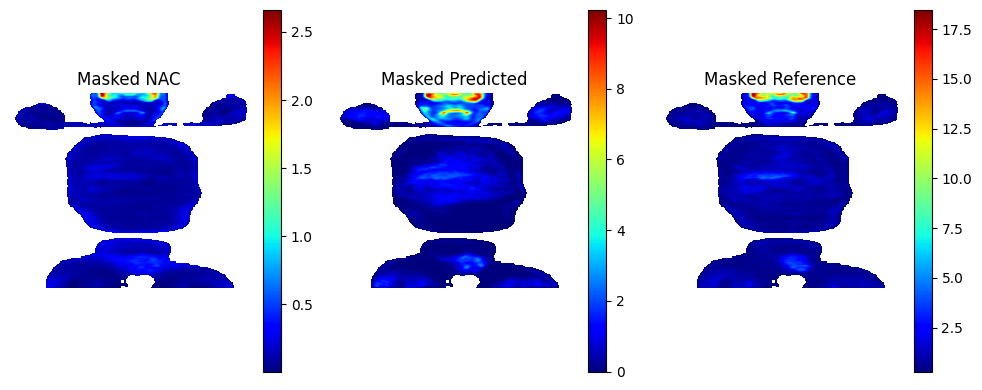

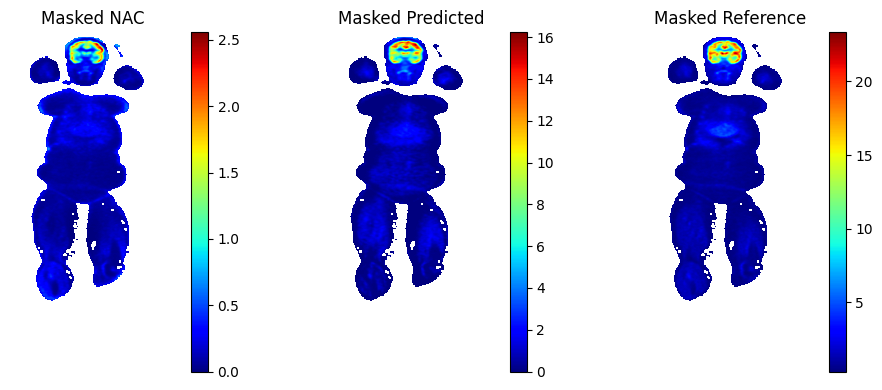

In [22]:
from quant import masked_SUV_img
from vis import visualize_coronal_masked

# Correctly iterate over pairs within each center group
for center, pairs in center_pairs_dyn.items():
    for pair in pairs:
        # Extract and mask images based on paths stored in 'pair' dictionary
        masked_nac_img, masked_predicted_img, masked_reference_img = masked_SUV_img(
            pair['nac'], pair['predicted'], pair['reference'], nac_factor, mac_factor, mask_val)
        # print(masked_nac_img)
        # Visualize a specific slice from the masked images
        visualize_coronal_masked(masked_nac_img, masked_predicted_img, masked_reference_img, slice_number=85)  # Adjust slice number as needed
        break

------------------
# Quantification Metrics

In [23]:
import pandas as pd

# Assuming calculate_metrics_for_pair and your data loading functions are correctly implemented
from quant import calculate_metrics_for_pair


# Calculate metrics for the ADCM dataset
metrics_adcm = []
for center, pairs in center_pairs_adcm.items():
    for pair in pairs:
        metrics = calculate_metrics_for_pair(pair['nac'], pair['predicted'], pair['reference'], nac_factor, mac_factor, mask_val)
        metrics['Center'] = center
        metrics['Dataset'] = 'ADCM'  # Label this group of metrics
        metrics_adcm.append(metrics)

# Create DataFrame from ADCM metrics list
df_adcm = pd.DataFrame(metrics_adcm)

# Calculate metrics for the Multi-center dataset
metrics_multi = []
for center, pairs in center_pairs_dyn.items():
    for pair in pairs:
        metrics = calculate_metrics_for_pair(pair['nac'], pair['predicted'], pair['reference'], nac_factor, mac_factor, mask_val)
        metrics['Center'] = center
        metrics['Dataset'] = 'Multi-Center'  # Label this group of metrics
        metrics_multi.append(metrics)

# Create DataFrame from Multi-center metrics list
df_multi = pd.DataFrame(metrics_multi)

# Concatenate both dataframes into a single dataframe
df_combined = pd.concat([df_adcm, df_multi])

# Display the first few rows of the combined DataFrame
df_combined


Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.
Masking successful.


,Mean Error (SUV),Mean Absolure Error (SUV),Relative Error (SUV%),Absolure Relative Error (SUV%),Root Mean Squared Error,Peak Signal-to-Noise Ratio,Structual Similarity Index,Center,Dataset
0,0.922312,1.164954,81.163557,95.087844,2.881750,38.660804,0.850557,C6,ADCM
1,0.670506,1.173514,43.733601,80.648891,4.148767,33.726892,0.750708,C6,ADCM
2,0.126372,0.833950,21.497199,63.732136,2.626467,34.958001,0.679669,C6,ADCM
3,-0.284092,0.926313,2.055585,53.891931,2.347692,37.845244,0.899650,C6,ADCM
4,-0.253572,1.065186,-8.066486,64.590468,2.836446,38.195606,0.633506,C6,ADCM
5,1.927583,2.072728,189.852360,195.734980,3.237517,33.038819,0.643329,C6,ADCM
6,0.863009,1.273916,92.752021,109.196981,2.789048,34.707351,0.757589,C6,ADCM
7,0.211914,0.845946,19.262183,59.954686,2.486913,41.085050,0.906959,C6,ADCM
8,0.834133,1.075885,66.699342,81.082111,2.217573,39.361289,0.860772,C6,ADCM
9,1.176651,1.458675,107.674337,139.463187,2.542297,34.490247,0.609434,C6,ADCM


In [24]:
df_combined.to_csv('Results/metric_data_fdg.csv', index=False)
# metric_data_fdg
# metric_data_ga

comb_3_27_onfdg:
Mean Error (SUV): -0.48 ± 0.1457
Mean Absolure Error (SUV): 0.70 ± 0.1316
Relative Error (SUV%): -18.30 ± 20.5247
Absolure Relative Error (SUV%): 54.24 ± 9.3453
Root Mean Squared Error: 1.48 ± 0.8662
Peak Signal-to-Noise Ratio: 31.04 ± 5.7015
Structual Similarity Index: 0.79 ± 0.0788

comb_3_27_onfdg_v2:
Mean Error (SUV): -0.04 ± 0.0883
Mean Absolure Error (SUV): 0.37 ± 0.0903
Relative Error (SUV%): 2.98 ± 10.5086
Absolure Relative Error (SUV%): 34.29 ± 9.0125
Root Mean Squared Error: 0.71 ± 0.3238
Peak Signal-to-Noise Ratio: 38.23 ± 5.6998
Structual Similarity Index: 0.92 ± 0.0386


dl_final_3_29:
Mean Error (SUV): -0.42 ± 0.0783
Mean Absolure Error (SUV): 0.42 ± 0.0767
Relative Error (SUV%): -72.41 ± 10.2247
Absolure Relative Error (SUV%): 72.65 ± 9.9125
Root Mean Squared Error: 0.57 ± 0.1856
Peak Signal-to-Noise Ratio: 22.53 ± 6.7792
Structual Similarity Index: 0.44 ± 0.1617

dl_final_3_29_v2: 
Mean Error (SUV): -0.32 ± 0.1032
Mean Absolure Error (SUV): 0.33 ± 0.0868
Relative Error (SUV%): -55.49 ± 15.6193
Absolure Relative Error (SUV%): 56.98 ± 13.3306
Root Mean Squared Error: 0.48 ± 0.1741
Peak Signal-to-Noise Ratio: 23.92 ± 6.4356
Structual Similarity Index: 0.63 ± 0.1537

dl_final_4_26
Mean Error (SUV): 0.35 ± 1.9522
Mean Absolure Error (SUV): 3.07 ± 1.1359
Relative Error (SUV%): -5.89 ± 28.9691
Absolure Relative Error (SUV%): 59.33 ± 11.5226
Root Mean Squared Error: 12.09 ± 6.8042
Peak Signal-to-Noise Ratio: 36.20 ± 4.1976
Structual Similarity Index: 0.83 ± 0.1090

dl_4_23:
comb_3_27_onfdg:
Mean Error (SUV): -0.48 ± 0.1457
Mean Absolure Error (SUV): 0.70 ± 0.1316
Relative Error (SUV%): -18.30 ± 20.5247
Absolure Relative Error (SUV%): 54.24 ± 9.3453
Root Mean Squared Error: 1.48 ± 0.8662
Peak Signal-to-Noise Ratio: 31.04 ± 5.7015
Structual Similarity Index: 0.79 ± 0.0788

comb_3_27_onfdg_v2:
Mean Error (SUV): -0.04 ± 0.0883
Mean Absolure Error (SUV): 0.37 ± 0.0903
Relative Error (SUV%): 2.98 ± 10.5086
Absolure Relative Error (SUV%): 34.29 ± 9.0125
Root Mean Squared Error: 0.71 ± 0.3238
Peak Signal-to-Noise Ratio: 38.23 ± 5.6998
Structual Similarity Index: 0.92 ± 0.0386


dl_final_3_29:
Mean Error (SUV): -0.42 ± 0.0783
Mean Absolure Error (SUV): 0.42 ± 0.0767
Relative Error (SUV%): -72.41 ± 10.2247
Absolure Relative Error (SUV%): 72.65 ± 9.9125
Root Mean Squared Error: 0.57 ± 0.1856
Peak Signal-to-Noise Ratio: 22.53 ± 6.7792
Structual Similarity Index: 0.44 ± 0.1617

dl_final_3_29_v2: 
Mean Error (SUV): -0.32 ± 0.1032
Mean Absolure Error (SUV): 0.33 ± 0.0868
Relative Error (SUV%): -55.49 ± 15.6193
Absolure Relative Error (SUV%): 56.98 ± 13.3306
Root Mean Squared Error: 0.48 ± 0.1741
Peak Signal-to-Noise Ratio: 23.92 ± 6.4356
Structual Similarity Index: 0.63 ± 0.1537

dl_final_4_26
Mean Error (SUV): 0.35 ± 1.9522
Mean Absolure Error (SUV): 3.07 ± 1.1359
Relative Error (SUV%): -5.89 ± 28.9691
Absolure Relative Error (SUV%): 59.33 ± 11.5226
Root Mean Squared Error: 12.09 ± 6.8042
Peak Signal-to-Noise Ratio: 36.20 ± 4.1976
Structual Similarity Index: 0.83 ± 0.1090

------------------
# Box Plots

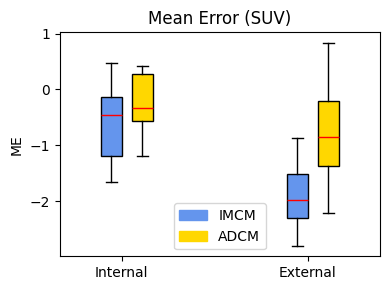

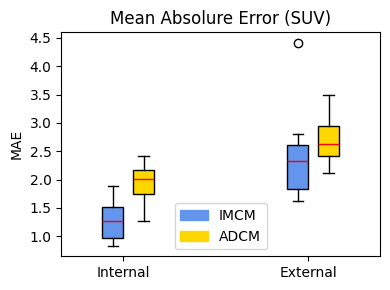

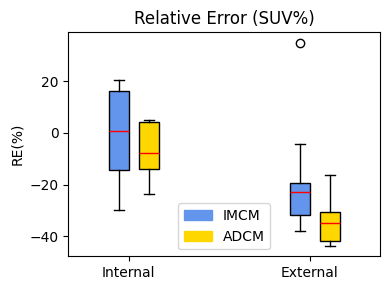

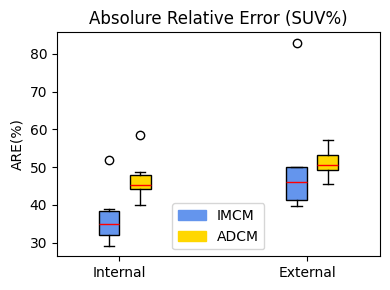

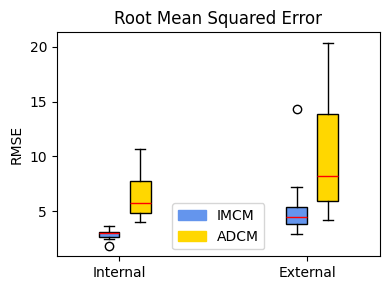

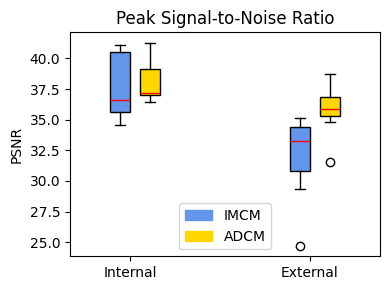

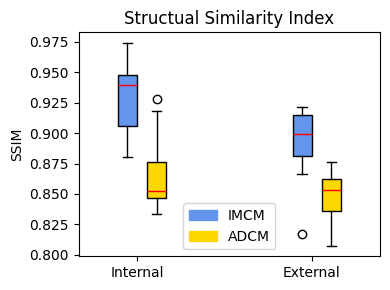

In [11]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define metrics names and titles for the plots
metrics_names = ['Mean Error (SUV)', 'Mean Absolure Error (SUV)', 'Relative Error (SUV%)', 'Absolure Relative Error (SUV%)', 'Root Mean Squared Error', 'Peak Signal-to-Noise Ratio', 'Structual Similarity Index']
subtitle = ['ME', 'MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
centers = ['Test', 'External']  # 'Test' for C1-C4, 'External' for C5
dataset_labels = ['Multi-Center', 'ADCM']  # Labels for datasets
dataset_colors = ['cornflowerblue', 'gold']  # Colors for each dataset
legend_label = ['IMCM', 'ADCM']
# Create patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(dataset_colors, legend_label)]

# Iterate over each metric and plot data for the grouped test centers and the external center
for i, metric in enumerate(metrics_names):
    plt.figure(figsize=(4, 3))  # Adjust the size as needed
    positions = []
    data_to_plot = []

    # Collect data for the combined test centers (C1 to C4) and external (C5)
    width = 0.2  # Width of the bars in the bar plot
    base_gap = 0.1  # Additional gap between dataset pairs within the same group
    inter_group_gap = 0.5  # Gap between test and external groups

    # Data for test centers
    test_data = []
    for dataset in dataset_labels:
        subset = df_combined[(df_combined['Center'].isin(['C1', 'C2', 'C3', 'C4', 'C6', 'C7'])) & (df_combined['Dataset'] == dataset)][metric]
        test_data.append(subset)
    data_to_plot.extend(test_data)
    positions.extend([1, 1 + width + base_gap])

    # Data for external center (C5)
    external_data = []
    for dataset in dataset_labels:
        subset = df_combined[(df_combined['Center'] == 'C5') & (df_combined['Dataset'] == dataset)][metric]
        external_data.append(subset)
    data_to_plot.extend(external_data)
    positions.extend([2 + width + base_gap + inter_group_gap, 2 + 2 * width + 2 * base_gap + inter_group_gap])

    # Create the boxplot
    bp = plt.boxplot(
        data_to_plot,
        positions=positions,
        widths=width,
        patch_artist=True,
        medianprops={'color': 'red', 'linewidth': 1}
    )

    # Set the face color for each box
    for box, color in zip(bp['boxes'], dataset_colors * 2):  # Twice for each group
        box.set_facecolor(color)

    # Custom x-tick labels, aligning them with the respective data groups
    plt.xticks([1 + width/2, 2 + width + base_gap + inter_group_gap + width/2], ['Internal', 'External'])

    plt.title(f"{metrics_names[i]}")
    plt.ylabel(subtitle[i])

    # Adding the legend to the plot
    plt.legend(handles=patches, loc='lower center')

    plt.tight_layout()
    plt.show()  # Display the plot


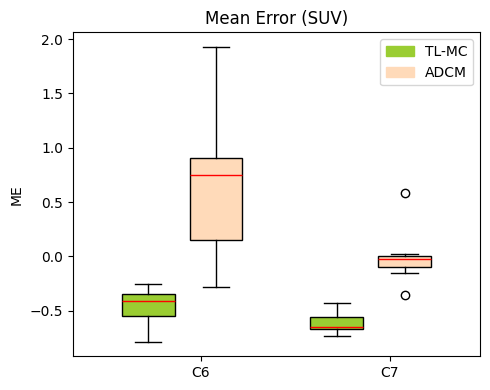

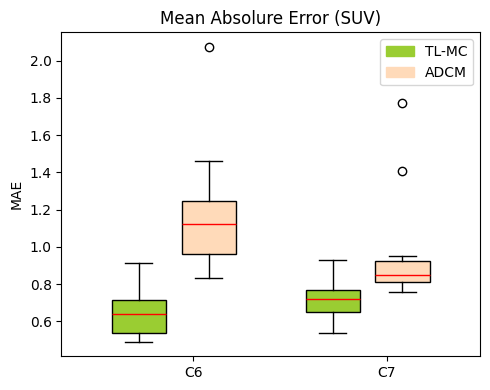

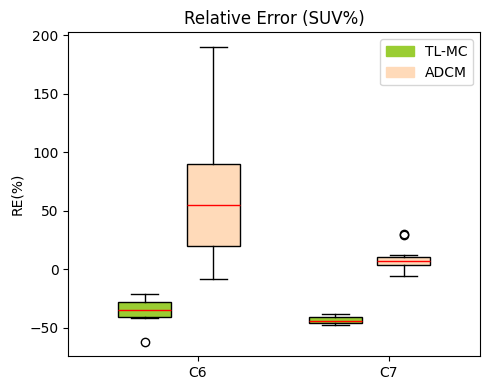

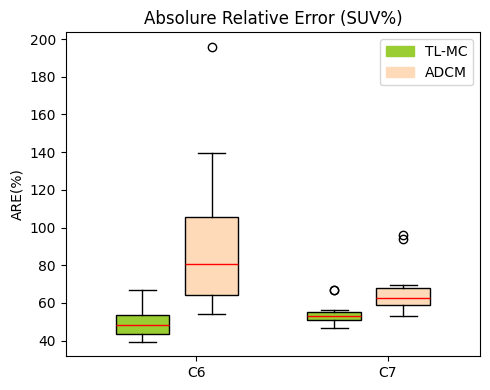

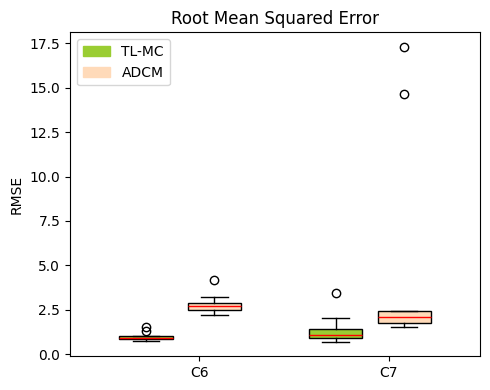

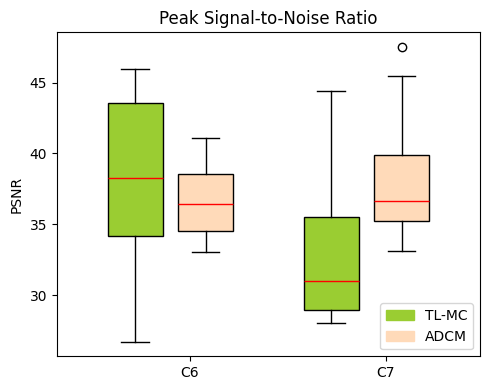

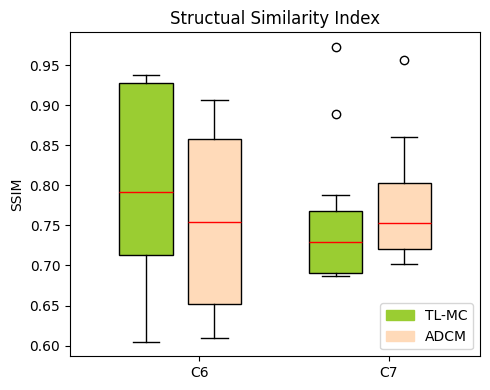

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define metrics names and titles for the plots
metrics_names = ['Mean Error (SUV)', 'Mean Absolure Error (SUV)', 'Relative Error (SUV%)', 'Absolure Relative Error (SUV%)', 'Root Mean Squared Error', 'Peak Signal-to-Noise Ratio', 'Structual Similarity Index']
subtitle = ['ME', 'MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
centers = df_combined['Center'].unique()  # Extract unique centers
dataset_labels = ['Multi-Center', 'ADCM']  # Labels for datasets
dataset_colors = ['cornflowerblue', 'gold']  # Colors for each dataset
dataset_colors = ['yellowgreen', 'wheat']
dataset_colors = ['yellowgreen', 'peachpuff']
legend_label = ['TL-MC', 'ADCM']
# Create patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(dataset_colors, legend_label)]

# Iterate over each metric and plot data for all centers and datasets
for i, metric in enumerate(metrics_names):
    plt.figure(figsize=(5, 4))  # Adjust the size as needed
    positions = []
    data_to_plot = []

    # Collect data for each center and dataset
    width = 0.35  # Width of the bars in the bar plot
    gap = 0.1  # Additional gap between pairs
    for j, center in enumerate(centers):
        center_base = j * (3 * width + 2 * gap)  # Adjust base position for each center, spacing them out more
        for k, dataset in enumerate(dataset_labels):
            subset = df_combined[(df_combined['Center'] == center) & (df_combined['Dataset'] == dataset)][metric]
            data_to_plot.append(subset)
            positions.append(center_base + k * (width + gap))  # Adjust for width to group datasets together

    # Create the boxplot
    bp = plt.boxplot(
        data_to_plot,
        positions=positions,
        widths=width,
        patch_artist=True,
        medianprops={'color': 'red', 'linewidth': 1}
    )

    # Set the face color for each box
    for box, color in zip(bp['boxes'], dataset_colors * len(centers)):
        box.set_facecolor(color)

    # Custom x-tick labels; position them between groups
    center_positions = [(j * (3 * width + 2 * gap) + width ) for j in range(len(centers))]
    plt.xticks(center_positions, centers)  # Only center names on x-axis

    plt.title(f"{metrics_names[i]}")
    plt.ylabel(subtitle[i])

    # Adding the legend to the plot
    plt.legend(handles=patches, loc='best')

    plt.tight_layout()
    plt.show()  # Display the plot


In [ ]:
# import matplotlib.pyplot as plt

# # Assuming the structure of all_metrics_dl3_18 and all_metrics_adcm as before,
# # we prepare the data.

# metrics_names = list(all_metrics_dl3_18[0].keys())  # Assuming metric names are the same across datasets
# combined_data = {metric: {'dl3_18': [], 'adcm': []} for metric in metrics_names}

# for entry in all_metrics_dl3_18:
#     for metric, value in entry.items():
#         combined_data[metric]['dl3_18'].append(value)

# for entry in all_metrics_adcm:
#     for metric, value in entry.items():
#         combined_data[metric]['adcm'].append(value)

# # Now, plot violin plots for each metric.
# plt.figure(figsize=(4, 3 * len(metrics_names)))  # Adjust the figure size as needed

# subtitle = ['ME','MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
# for i, metric in enumerate(metrics_names, 1):
#     plt.subplot(len(metrics_names), 1, i)
    
#     # Prepare the data for violin plot
#     data = [combined_data[metric]['dl3_18'], combined_data[metric]['adcm']]
#     plt.boxplot(data)
#     # plt.violinplot(data, )
    
#     # Adding custom x-tick labels
#     plt.xticks([1, 2], ['dl3_18', 'adcm'])
    
#     plt.title(metric)
#     plt.ylabel(subtitle[i-1])
# plt.tight_layout()
# plt.show()

In [ ]:
# # Define your colors for each category
# color_palette = ['blue', 'red']  # Choose your colors here

# for i, metric in enumerate(metrics):
#     plt.figure(figsize=(4, 3))

#     # Draw violin plots for each category
#     unique_categories = combined_df['dataset'].unique()
#     for j, category in enumerate(unique_categories):
#         category_data = combined_df[combined_df['dataset'] == category]
#         sns.violinplot(x='dataset', y=metric, data=category_data, 
#                        color=color_palette[j], linewidth=0.2, inner='quartile')

#     # Draw box plots for each category
#     for j, category in enumerate(unique_categories):
#         category_data = combined_df[combined_df['dataset'] == category]
#         sns.boxplot(x='dataset', y=metric, data=category_data, showcaps=True, 
#                     boxprops={'facecolor': 'w'}, showfliers=True, 
#                     whiskerprops={'linewidth': 2}, width=0.1, color=color_palette[j])

#     plt.ylabel(subtitle[i], fontsize=12)
#     plt.xlabel('')
#     plt.title(f"{subtitle[i]} ({metric})", fontsize=14)
#     plt.tight_layout()
#     plt.show()


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from matplotlib.font_manager import FontProperties


# # Convert your lists of dictionaries into DataFrames for easier manipulation
# df_dl3_18 = pd.DataFrame(all_metrics_dl3_18)
# df_adcm = pd.DataFrame(all_metrics_adcm)

# # Add a column to each dataframe to label the dataset
# df_dl3_18['dataset'] = 'dl3_18'
# df_adcm['dataset'] = 'adcm'

# # Combine the dataframes
# combined_df = pd.concat([df_dl3_18, df_adcm])
# legend_font_props = FontProperties()
# legend_font_props.set_size('13')
# # Now, plot box plots for each metric
# metrics = df_dl3_18.columns[:-1]  # Assuming the last column is the 'dataset' label
# subtitle = ['ME','MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
# for i, metric in enumerate(metrics):
#     plt.figure(figsize=(6, 4))
#     # Create the violin plot without splitting by 'hue'
#     sns.violinplot(x='dataset', y=metric, data=combined_df, palette='Set1', linewidth=0.5, inner=None)
    
#     # Create the box plot separately with adjusted width to be narrower
#     sns.boxplot(x='dataset', y=metric, data=combined_df, showcaps=False, 
#                 boxprops={'facecolor': 'None'}, showfliers=False, 
#                 whiskerprops={'linewidth': 0}, width=0.1)

#     plt.ylabel(subtitle[i], fontsize=12)
#     plt.xlabel('')
#     plt.title(f"ME (Mean Error (SUV))", fontsize=14)
#     plt.tight_layout()
#     plt.show()



------------------------------

In [ ]:
# from quant import calculate_metrics_for_pair, aggregate_metrics
# # Calculate metrics for each pair and aggregate results
# metrics_c5_adcm = [calculate_metrics_for_pair(
#     pair['predicted'], pair['reference'],
#     scaling_factor=5, mask_val = 0.3)
#     for pair in c5_pairs_adcm]

# metrics_rest_adcm = [calculate_metrics_for_pair(
#     pair['predicted'], pair['reference'],
#     scaling_factor=5, mask_val = 0.3)
#     for pair in rest_pairs_adcm]

# metrics_c5_dl3_18 = [calculate_metrics_for_pair(
#     pair['predicted'], pair['reference'],
#     scaling_factor=5, mask_val = 0.3)
#     for pair in c5_pairs_dl3_18]

# metrics_rest_dl3_18 = [calculate_metrics_for_pair(
#     pair['predicted'], pair['reference'],
#     scaling_factor=5, mask_val = 0.3)
#     for pair in rest_pairs_dl3_18]

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches


# # Assuming that each metric calculation returns a dictionary like before
# metrics_names = list(metrics_c5_adcm[0].keys())  # Metric names from the data
# subtitle = ['ME', 'MAE', 'RE(%)', 'ARE(%)', 'RMSE', 'PSNR', 'SSIM']
# colors = ['cornflowerblue', 'gold']  # Colors for c5s and rests
# # 'lightblue', 'lightcoral'


# for i, metric in enumerate(metrics_names):
#     plt.figure(figsize=(5, 3))  # Adjust the figure size
    
#     # Prepare data for c5s and rests for both datasets
#     data_c5_adcm = [entry[metric] for entry in metrics_c5_adcm]
#     data_rest_adcm = [entry[metric] for entry in metrics_rest_adcm]
#     data_c5_dl3_18 = [entry[metric] for entry in metrics_c5_dl3_18]
#     data_rest_dl3_18 = [entry[metric] for entry in metrics_rest_dl3_18]
    
#     # Create boxplots
#     positions = [1, 2, 4, 5]  # Position for each boxplot
#     data = [data_c5_dl3_18, data_rest_dl3_18, data_c5_adcm, data_rest_adcm]
#     boxplot_parts = plt.boxplot(data, positions=positions, patch_artist=True,
#                                 medianprops={'color': 'r', 'linewidth': 1})
    
#     # Set colors for each boxplot
#     for patch, position in zip(boxplot_parts['boxes'], positions):
#         color = colors[0] if position in [1, 4] else colors[1]
#         patch.set_facecolor(color)
    
#     # Custom x-tick labels
#     plt.xticks([1.5, 4.5], ['DL3_18', 'ADCM'])
#         # Create custom legend patches
    
#     rest_patch = mpatches.Patch(color=colors[0], label='Internal')
#     c5_patch = mpatches.Patch(color=colors[1], label='External')


#     # Add legend to the plot
#     plt.legend(handles=[c5_patch, rest_patch], loc='upper center')
#     plt.title(metrics_names[i])
#     plt.ylabel(subtitle[i])
    
#     plt.tight_layout()
#     plt.show()


-----------------

# Joint Histogram

In [ ]:
# from scipy.stats import linregress
# values_predicted_imcm = []
# values_reference_imcm= []

# for center, pairs in center_pairs_dyn.items():
#     for pair in pairs:
#         masked_nac_img, masked_predicted_img, masked_reference_img = masked_SUV_img(
#             pair['nac'], pair['predicted'], pair['reference'], nac_factor, mac_factor, mask_val=0.3)
#         predicted_flat = masked_predicted_img.ravel()
#         reference_flat = masked_reference_img.ravel()
#         values_predicted_imcm.extend(predicted_flat)
#         values_reference_imcm.extend(reference_flat)


# values_predicted_adcm = []
# values_reference_adcm= []
# for center, pairs in center_pairs_adcm.items():
#     for pair in pairs:
#         masked_nac_img, masked_predicted_img, masked_reference_img = masked_SUV_img(
#             pair['nac'], pair['predicted'], pair['reference'], nac_factor, mac_factor, mask_val=0.3)
#         predicted_flat = masked_predicted_img.ravel()
#         reference_flat = masked_reference_img.ravel()
#         values_predicted_adcm.extend(predicted_flat)
#         values_reference_adcm.extend(reference_flat)




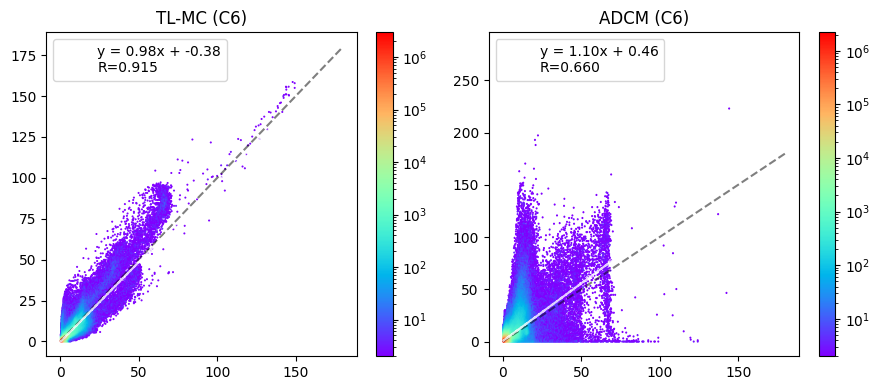

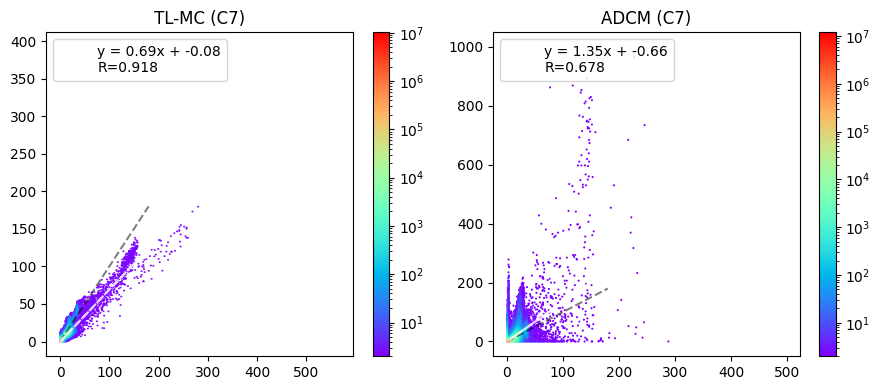

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np

def plot_joint_histogram(reference, predicted, ax, title, max_val, mask):
    reference = np.array(reference)
    predicted = np.array(predicted)

    # Apply a filtering threshold
    mask = predicted < mask
    reference_filtered = reference[mask]
    predicted_filtered = predicted[mask]

    # Plotting
    hexbin = ax.hexbin(reference_filtered, predicted_filtered, gridsize=400, cmap='rainbow', bins='log', mincnt=2)
    plt.colorbar(hexbin, ax=ax)

    # Add a bisector line
    ax.plot([0, max_val], [0, max_val], 'k--', alpha =0.5)
    # Regression analysis on the filtered data
    if len(reference_filtered) > 1:
        slope, intercept, r_value, _, _ = linregress(reference_filtered, predicted_filtered)
        ax.plot(reference_filtered, intercept + slope * reference_filtered, 'w--', label=f'y = {slope:.2f}x + {intercept:.2f}\nR={r_value:.3f}', alpha = 0.8)


    ax.set_title(title)
    ax.legend(loc="upper left")

def prepare_and_plot_data(pairs, dataset_label, ax, max_val):
    values_predicted = []
    values_reference = []
    for pair in pairs:
        # Assuming 'masked_SUV_img' is a function that properly masks your images
        _, masked_predicted_img, masked_reference_img = masked_SUV_img(
            pair['nac'], pair['predicted'], pair['reference'], nac_factor, mac_factor, mask_val=0.3)
        values_predicted.extend(masked_predicted_img.ravel())
        values_reference.extend(masked_reference_img.ravel())

    plot_joint_histogram(values_reference, values_predicted, ax, f'{dataset_label}', max_val, mask)

mask = 1000
centers = ['C1', 'C2', 'C3', 'C4', 'C5']  # list of centers for Ga
centers = ['C6', 'C7']  # list of centers for FDG
# max_val = 350  # Define a maximum value for threshold

for center in centers:
    fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=False, sharex=False)
    prepare_and_plot_data(center_pairs_dyn[center], f'TL-MC ({center})', axs[0], max_val=180)
    prepare_and_plot_data(center_pairs_adcm[center], f'ADCM ({center})', axs[1], max_val=180)
    plt.tight_layout()
    plt.show()


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
# from scipy.stats import linregress

# def create_density_scatter_plot(suv_predicted, suv_reference, dataset_label, sample_size=None):
#     # Ensure the data is in the form of 1D NumPy arrays
#     suv_predicted = np.asarray(suv_predicted).flatten()
#     suv_reference = np.asarray(suv_reference).flatten()

#     # Sample the data to speed up the process if needed
#     if sample_size is not None and len(suv_predicted) > sample_size:
#         idx = np.random.choice(len(suv_predicted), size=sample_size, replace=False)
#         suv_predicted = suv_predicted[idx]
#         suv_reference = suv_reference[idx]

#     # Calculate the point density using Gaussian KDE
#     xy = np.vstack([suv_reference, suv_predicted])
#     z = gaussian_kde(xy)(xy)
    
#     # Sort the points by density, so the densest points are plotted last
#     idx = z.argsort()
#     suv_reference, suv_predicted, z = suv_reference[idx], suv_predicted[idx], z[idx]
    
#     # Calculate regression line and R-squared value
#     slope, intercept, r_value, p_value, std_err = linregress(suv_reference, suv_predicted)
#     regression_line = slope * suv_reference + intercept

#     # Create the scatter plot
#     plt.figure(figsize=(8, 6))
#     scatter = plt.scatter(suv_reference, suv_predicted, c=z, s=10, cmap='rainbow')
#     plt.colorbar(scatter, label='Density')
#     plt.plot(suv_reference, regression_line, color='black', linestyle='dashed', linewidth=1)
#     plt.title(f'{dataset_label} Density Scatter Plot')
#     plt.xlabel('Reference SUV')
#     plt.ylabel('Predicted SUV')

#     # Annotation for regression line equation and R-squared
#     plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', fontsize=12, color='white')

#     # Show plot
#     plt.show()

# # Replace with your actual data
# create_density_scatter_plot(suv_predicted_adcm, suv_reference_adcm, 'ADCM', sample_size=500000)
# create_density_scatter_plot(suv_predicted_dl3_18, suv_reference_dl3_18, 'DL3_18', sample_size=500000)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde
# from scipy.stats import linregress

# def create_density_scatter_plot(suv_predicted, suv_reference, dataset_label):
#     # Calculate the point density
#     xy = np.vstack([suv_reference, suv_predicted])
#     z = gaussian_kde(xy)(xy)

#     # Sort the points by density, so that the densest points are plotted last
#     idx = z.argsort()
#     suv_reference, suv_predicted, z = suv_reference[idx], suv_predicted[idx], z[idx]
    
#     # Calculate regression line and R-squared value
#     slope, intercept, r_value, _, _ = linregress(suv_reference, suv_predicted)
#     regression_line = slope * suv_reference + intercept

#     # Create the density scatter plot
#     plt.figure(figsize=(8, 6))
#     scatter = plt.scatter(suv_reference, suv_predicted, c=z, s=50, edgecolor='', cmap='rainbow')
#     plt.colorbar(scatter, label='Density')
    
#     # Plot regression line
#     plt.plot(suv_reference, regression_line, color='red', linestyle='dashed', linewidth=2)

#     # Annotations for regression line equation and R-squared
#     plt.annotate(f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.3f}',
#                  xy=(0.05, 0.95), xycoords='axes fraction', 
#                  ha='left', va='top', color='red', fontsize=12,
#                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

#     # Set labels and title
#     plt.xlabel('Reference SUV')
#     plt.ylabel('Predicted SUV')
#     plt.title(f'Density Scatter Plot for {dataset_label}')

#     # Show the plot
#     plt.show()

# # Generate and show density scatter plots for both datasets
# create_density_scatter_plot(suv_predicted_adcm, suv_reference_adcm, 'ADCM')
# create_density_scatter_plot(suv_predicted_dl3_18, suv_reference_dl3_18, 'DL3_18')


In [ ]:

# # Plot using seaborn's regplot, which includes a regression line and 95% CI by default
# plt.figure(figsize=(8, 6))
# ax = sns.regplot(x=suv_reference_adcm, y=suv_predicted_adcm, ci=95, color='b', scatter_kws={'alpha':0.3})

# # You can set the facecolor of the axes to match the lowest color in the colormap
# ax.set_facecolor('#280137')  # Adjust the color code to match your colormap's lowest value

# # Labels and title
# plt.xlabel('Reference SUV')
# plt.ylabel('Predicted SUV')
# plt.title('Regression Analysis with 95% CI')

# # Show the plot
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Calculate regression values
slope, intercept, r_value, p_value, std_err = stats.linregress(suv_reference_adcm, suv_predicted_adcm)

# Define a function for the regression line
def predict(x):
    return slope * x + intercept

# Predict values along the regression line
line = predict(suv_reference_adcm)

# Calculate the confidence interval
confidence_level = 0.95
degrees_freedom = len(suv_reference_adcm) - 2
t_critical = np.abs(stats.t.ppf((1 - confidence_level) / 2, degrees_freedom))
s_err = np.sum((suv_predicted_adcm - line)**2) / degrees_freedom
conf_interval = t_critical * np.sqrt((s_err/(len(suv_reference_adcm)-1))*(1 + (suv_reference_adcm-np.mean(suv_reference_adcm))**2/np.sum((suv_reference_adcm-np.mean(suv_reference_adcm))**2)))

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(suv_reference_adcm, suv_predicted_adcm, alpha=0.5)
plt.plot(suv_reference_adcm, line, color='red', label=f'Linear Regression\n$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.3f}$')

# Fill the confidence interval
plt.fill_between(suv_reference_adcm, line - conf_interval, line + conf_interval, color='red', alpha=0.2, label='95% Confidence Interval')

# Set the background color
plt.gca().set_facecolor('#280137')

# Labels and title
plt.xlabel('Reference SUV')
plt.ylabel('Predicted SUV')
plt.title('Regression Analysis with 95% CI')
plt.legend()

# Show the plot
plt.show()


# Results for Dynunet without matching the networks prameters:
mean_error: -0.25 ± 0.0722
mean_absolute_error: 0.43 ± 0.0803
relative_error: 7.56 ± 7.7195
absolute_relative_error: 38.52 ± 4.3638
rmse: 2.10 ± 0.9815
psnr: 39.60 ± 3.0782
ssim: 0.97 ± 0.0040


# Results for Dyunet with matching the networks prameters:

mean_error: -0.27 ± 0.0802
mean_absolute_error: 0.37 ± 0.0524
relative_error: -14.82 ± 2.6155
absolute_relative_error: 35.17 ± 3.3576
rmse: 1.60 ± 0.3624
psnr: 41.57 ± 2.2030
ssim: 0.97 ± 0.0056


# Resulats for Dyunet after some augmentation:

mean_error: -0.13 ± 0.1053
mean_absolute_error: 0.29 ± 0.1097
relative_error: 11.28 ± 9.1598
absolute_relative_error: 24.58 ± 7.9870
rmse: 1.59 ± 0.9717
psnr: 43.46 ± 4.1015
ssim: 0.98 ± 0.0063

# Results for re-trained model with fdg data on fdg datatest
mean_error: 0.02 ± 0.0064
mean_absolute_error: 0.08 ± 0.0111
relative_error: 6.71 ± 0.0923
absolute_relative_error: 10.90 ± 0.1017
rmse: 0.30 ± 0.0762
psnr: 46.35 ± 6.6213
ssim: 0.98 ± 0.0056